In [1]:
%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False

### Setup

First, we load all the packages required for running the five algorithms and analyzing their performance.

In [2]:
from sklearn import preprocessing
from sklearn import svm
from sklearn import tree

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import time

import warnings
warnings.filterwarnings('ignore')

### Data Preprocessing

This is one of the most important steps: cleaning up the data. Fortunately, most datasets derived from the UCI data repository is already clean, and therefore, the preprocessing step involves minor cleanup. Mainly, we change the 'M' and 'B' labels to $1$ and $0$ respectively, and drop the unnecessary columns as features (e.g., `id`, `Unnamed: 32`). 

We then scale the features and split the data into training and testing sets.

In [3]:
data = pd.read_csv('data/rice-cammeo-osmanick.csv')

y = data.CLASS
X = data.drop(['CLASS'], axis=1)
y = y.values
y[y == 'Cammeo'] = 0
y[y == 'Osmancik'] = 1
y = y.astype(int)

print("Number of samples:", y.size)
print("Percentage of Osmancik cases:", y[y==1].size/y.size*100)

print("Splitting into train/test sets...")
X = preprocessing.scale(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print("Setting up global variables...")
classifier_accuracy = np.zeros(6)
time_train = np.zeros(6)
time_infer = np.zeros(6)

Number of samples: 3810
Percentage of Osmancik cases: 57.21784776902887
Splitting into train/test sets...
Setting up global variables...


### Decision Trees

We first start with a simple decision tree classifier. `sklearn` has an extremely intuitive interface that allows us to implement these classifiers with only a few lines of code.

For decision trees, one of the methods to prevent overfitting is to control the maximum depth of the tree as a hyper-parameter. We use cross-validation over a range of hyper-parameter values to find the best value for the maximum depth of the tree. For this, we use the `validation_curve` and `GridSearchCV` functions.

The second hyper-parameter that is often important for overfitting is a minimal cost-complexity pruning (CCP), where the regularization parameter $\alpha$ allows us to prune the tree after it has been trained. Higher values of $\alpha$ leads to more nodes being pruned out from the tree.

For the maximum depth of the tree, we see that the training score in the validation curve saturates at $1$ as the model starts to overfit for higher values of max depth.

For the CCP $\alpha$, the training and cross-validation scores stabilize at a fixed value with increasing $\alpha$.

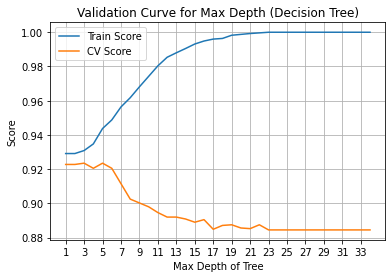

In [4]:
classifier_decision_tree = tree.DecisionTreeClassifier(random_state=42)
train_scores, test_scores = validation_curve(classifier_decision_tree, X_train, y_train, param_range=np.arange(1,35), param_name='max_depth', cv=4)

plt.figure()
plt.plot(np.arange(1,35), np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.arange(1,35), np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Validation Curve for Max Depth (Decision Tree)")
plt.xlabel("Max Depth of Tree")
plt.ylabel("Score")
plt.xticks(np.arange(1,35,2))
plt.grid()
plt.savefig('rice_decision_tree_validation_curve_1.png')
plt.show()

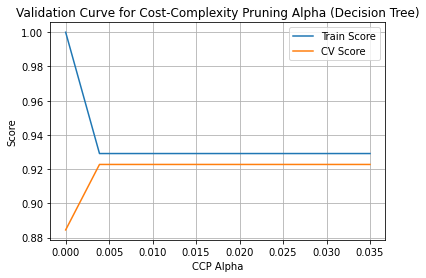

In [5]:
train_scores, test_scores = validation_curve(classifier_decision_tree, X_train, y_train, param_range=np.linspace(0,0.035,10), param_name='ccp_alpha', cv=4)

plt.figure()
plt.plot(np.linspace(0,0.035,10), np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.linspace(0,0.035,10), np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Validation Curve for Cost-Complexity Pruning Alpha (Decision Tree)")
plt.xlabel("CCP Alpha")
plt.ylabel("Score")
plt.xticks(np.linspace(0,0.035,8))
plt.grid()
plt.savefig('rice_decision_tree_validation_curve_2.png')
plt.show()

In [6]:
param_grid = {'max_depth': np.arange(1,35), 'ccp_alpha': np.linspace(0,0.035,10)}
classifier_decision_tree_best = GridSearchCV(classifier_decision_tree, param_grid=param_grid, cv=4)

start_time = time.time()
classifier_decision_tree_best.fit(X_train, y_train)
end_time = time.time()
time_train[0] = end_time-start_time
print("Best params for decision tree:",classifier_decision_tree_best.best_params_)

start_time = time.time()
classifier_accuracy[0] = accuracy_score(y_test, classifier_decision_tree_best.predict(X_test))
end_time = time.time()
time_infer[0] = end_time-start_time
print("Accuracy for best decision tree:", classifier_accuracy[0])


Best params for decision tree: {'ccp_alpha': 0.0, 'max_depth': 3}
Accuracy for best decision tree: 0.9300087489063867


In [7]:
confusion_matrix(y_test, classifier_decision_tree_best.predict(X_test))

array([[467,  51],
       [ 29, 596]], dtype=int64)

We see that the decision tree with a tree depth of $3$ and a CCP $\alpha$ of $0$ performs the best (these are relatively good values as seen from the validation curves as well). The performance of the best classifier on the test set is also high, with an accuracy score of $93.00\%$.

Next, we look at the learning curve for the decision tree. We vary the percentage of data used for training, and plot the training and cross-validation score.

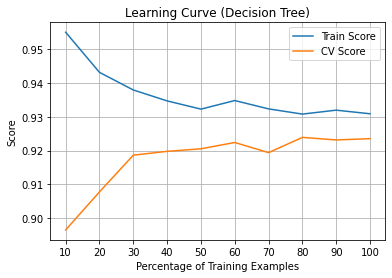

In [8]:
classifier_decision_tree_learning = tree.DecisionTreeClassifier(random_state=42, max_depth=classifier_decision_tree_best.best_params_['max_depth'], ccp_alpha=classifier_decision_tree_best.best_params_['ccp_alpha'])
_, train_scores, test_scores = learning_curve(classifier_decision_tree_learning, X_train, y_train, train_sizes=np.linspace(0.1,1.0,10), cv=4)

plt.figure()
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Learning Curve (Decision Tree)")
plt.xlabel("Percentage of Training Examples")
plt.ylabel("Score")
plt.xticks(np.linspace(0.1,1.0,10)*100)
plt.grid()
plt.savefig('rice_decision_tree_learning_curve.png')
plt.show()

In this case, the gap between the train score and the CV score is relatively lower at higher percentage of training examples, which means that since the final converged score can be higher, there might be bias in the model and it could benefit from increased model complexity.

### Neural Network/Perceptron

The next classifier that we will use is a neural network classifier. We do not need an overly complex neural network architecture. We choose an architecture with two hidden layers, with each layer containing $4$ nodes each. The same procedure as in the decision trees section is then followed. 

We start with the validation curve. In the case of a neural network classifier, we can choose multiple hyper-parameters. The ones chosen here are learning rate and the regularization parameter ($\alpha$) as these tend to have a larger effect on the performance of the model.

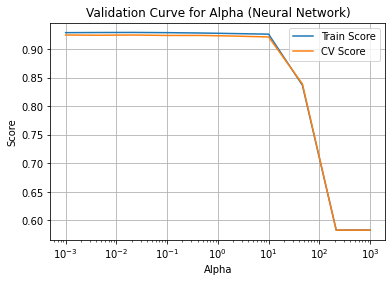

In [9]:
classifier_neural_network = MLPClassifier(hidden_layer_sizes=(4, 4), random_state=42, max_iter=2000)
train_scores, test_scores = validation_curve(classifier_neural_network, X_train, y_train, param_name="alpha", param_range=np.logspace(-4,3,10), cv=4)

plt.figure()
plt.semilogx(np.logspace(-3,3,10), np.mean(train_scores, axis=1), label='Train Score')
plt.semilogx(np.logspace(-3,3,10), np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Validation Curve for Alpha (Neural Network)")
plt.xlabel("Alpha")
plt.ylabel("Score")
plt.grid()
plt.savefig('rice_neural_network_validation_curve_1.png')
plt.show()

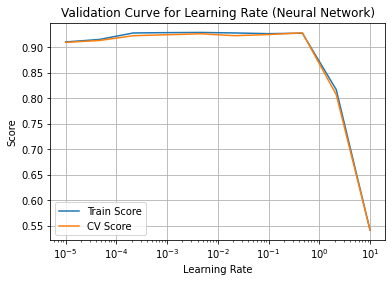

In [10]:
train_scores, test_scores = validation_curve(classifier_neural_network, X_train, y_train, param_name="learning_rate_init", param_range=np.logspace(-5,1,10), cv=4)

plt.figure()
plt.semilogx(np.logspace(-5,1,10), np.mean(train_scores, axis=1), label='Train Score')
plt.semilogx(np.logspace(-5,1,10), np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Validation Curve for Learning Rate (Neural Network)")
plt.xlabel("Learning Rate")
plt.ylabel("Score")
plt.grid()
plt.savefig('rice_neural_network_validation_curve_2.png')
plt.show()

Looking at the validation curves, the grid for the hyper-parameter cross-validation search is decided, and the results are shown below. It can be seen that the best values of parameters are $\alpha = 0.1$ and learning rate as $0.1$, with an accuracy of $92.21\%$ on the test set. However, the cost of this high accuracy is the large training time required by even such a simple neural network model.

In [11]:
param_grid = {'alpha': np.logspace(-3,3,7), 'learning_rate_init': np.logspace(-5,1,7)}
classifier_neural_network_best = GridSearchCV(classifier_neural_network, param_grid=param_grid, cv=4)

start_time = time.time()
classifier_neural_network_best.fit(X_train, y_train)
end_time = time.time()
time_train[1] = end_time-start_time
print("Best params for neural network:",classifier_neural_network_best.best_params_)

start_time = time.time()
classifier_accuracy[1] = accuracy_score(y_test, classifier_neural_network_best.predict(X_test))
end_time = time.time()
time_infer[1] = end_time-start_time
print("Accuracy for best neural network:", classifier_accuracy[1])

Best params for neural network: {'alpha': 0.1, 'learning_rate_init': 0.1}
Accuracy for best neural network: 0.9221347331583553


In [12]:
confusion_matrix(y_test, classifier_neural_network_best.predict(X_test))

array([[447,  71],
       [ 18, 607]], dtype=int64)

We also look at the learning curve for the neural network classifier, and it is symptomatic of a model with bias since the convergence in training and cross-validation scores occurs at high percentage of training examples, but the score at convergence is not high enough (~$0.93$).

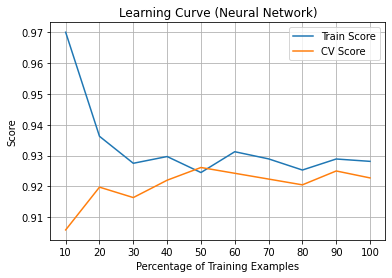

In [13]:
classifier_neural_network_learning = MLPClassifier(hidden_layer_sizes=(4, 4), random_state=42, max_iter=2000, learning_rate_init=classifier_neural_network_best.best_params_['learning_rate_init'], alpha=classifier_neural_network_best.best_params_['alpha'])
_, train_scores, test_scores = learning_curve(classifier_neural_network_learning, X_train, y_train, train_sizes=np.linspace(0.1,1.0,10), cv=4)

plt.figure()
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Learning Curve (Neural Network)")
plt.xlabel("Percentage of Training Examples")
plt.ylabel("Score")
plt.xticks(np.linspace(0.1,1.0,10)*100)
plt.grid()
plt.savefig('rice_neural_network_learning_curve.png')
plt.show()

We also look at the loss curves for the neural network, which shows how the error in training reduces with the number of epochs. For this, we use the same model structure and hyper-parameters as derived above, and show the results on training, validation and test sets.

In [14]:
classifier_neural_network = MLPClassifier(hidden_layer_sizes=(4, 4), random_state=42, max_iter=1, alpha=classifier_neural_network_best.best_params_['alpha'], learning_rate_init=classifier_neural_network_best.best_params_['learning_rate_init'], warm_start=True)
epochs = 300
loss_training = np.zeros(epochs)
score_training = np.zeros(epochs)
score_validation = np.zeros(epochs)

X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
for epoch in range(epochs):
    classifier_neural_network.fit(X_train_train, y_train_train)
    
    score_training[epoch] = accuracy_score(y_train_train, classifier_neural_network.predict(X_train_train))
    score_validation[epoch] = accuracy_score(y_train_val, classifier_neural_network.predict(X_train_val))
    
    loss_training[epoch] = classifier_neural_network.loss_
    
score_test = accuracy_score(y_test, classifier_neural_network.predict(X_test))
print("Test set accuracy:", score_test)
    

Test set accuracy: 0.931758530183727


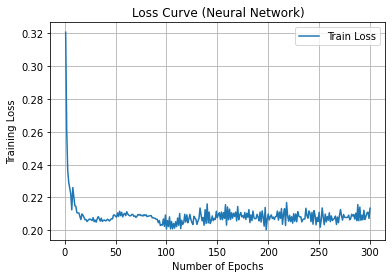

In [15]:
plt.figure()
plt.plot(np.arange(epochs)+1, loss_training, label='Train Loss')
plt.legend()
plt.title("Loss Curve (Neural Network)")
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss")
plt.grid()
plt.savefig('rice_neural_network_loss_curve.png')
plt.show()

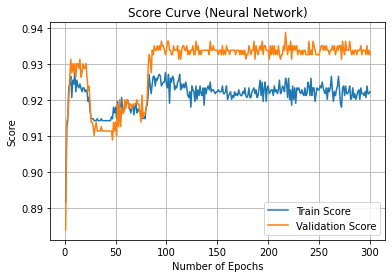

In [16]:
plt.figure()
plt.plot(np.arange(epochs)+1, score_training, label='Train Score')
plt.plot(np.arange(epochs)+1, score_validation, label='Validation Score')
plt.legend()
plt.title("Score Curve (Neural Network)")
plt.xlabel("Number of Epochs")
plt.ylabel("Score")
plt.grid()
plt.savefig('rice_neural_network_score_curve.png')
plt.show()

The training loss keeps decreasing with increasing number of epochs as expected from the network. The high training and validation scores showcase the good performance of the neural network classifier even after $300$ epochs.

Next, we look at single layer neural networks with varying number of hidden units as one of the hyper-parameters. The validation curve in this case is inconclusive for the number of hidden units as the score values remain very stable throughout the range of values.

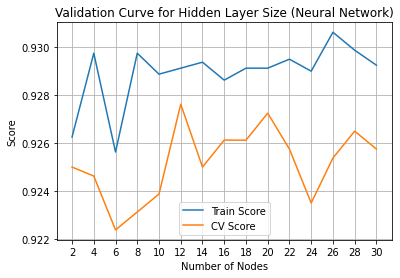

In [17]:
classifier_neural_network = MLPClassifier(random_state=42, max_iter=2000)
train_scores, test_scores = validation_curve(classifier_neural_network, X_train, y_train, param_name="hidden_layer_sizes", param_range=np.arange(2,31,2), cv=4)

plt.figure()
plt.plot(np.arange(2,31,2), np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.arange(2,31,2), np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Validation Curve for Hidden Layer Size (Neural Network)")
plt.xlabel("Number of Nodes")
plt.ylabel("Score")
plt.grid()
plt.xticks(np.arange(2,31,2))
plt.savefig('rice_neural_network_validation_curve_3.png')
plt.show()

For the RCO dataset, the results are slightly better than the two-layer network, with a better distribution of false positives and negatives.

In [18]:
param_grid = {'alpha': np.logspace(-3,3,10), 'hidden_layer_sizes': np.arange(2,31,2)}
classifier_neural_network_best = GridSearchCV(classifier_neural_network, param_grid=param_grid, cv=4)

start_time = time.time()
classifier_neural_network_best.fit(X_train, y_train)
end_time = time.time()
time_train[2] = end_time-start_time
print("Best params for neural network:",classifier_neural_network_best.best_params_)

start_time = time.time()
classifier_accuracy[2] = accuracy_score(y_test, classifier_neural_network_best.predict(X_test))
end_time = time.time()
time_infer[2] = end_time-start_time
print("Accuracy for best neural network:", classifier_accuracy[2])

Best params for neural network: {'alpha': 0.46415888336127775, 'hidden_layer_sizes': 12}
Accuracy for best neural network: 0.931758530183727


In [19]:
confusion_matrix(y_test, classifier_neural_network_best.predict(X_test))

array([[472,  46],
       [ 32, 593]], dtype=int64)

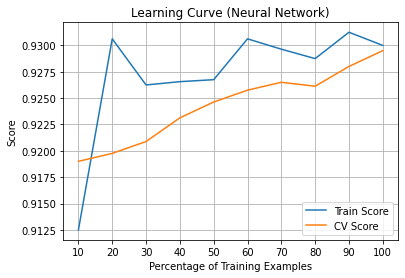

In [20]:
classifier_neural_network_learning = MLPClassifier(random_state=42, max_iter=2000, hidden_layer_sizes=classifier_neural_network_best.best_params_['hidden_layer_sizes'], alpha=classifier_neural_network_best.best_params_['alpha'])
_, train_scores, test_scores = learning_curve(classifier_neural_network_learning, X_train, y_train, train_sizes=np.linspace(0.1,1.0,10), cv=4)

plt.figure()
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Learning Curve (Neural Network)")
plt.xlabel("Percentage of Training Examples")
plt.ylabel("Score")
plt.xticks(np.linspace(0.1,1.0,10)*100)
plt.grid()
plt.savefig('rice_neural_network_learning_curve_2.png')
plt.show()

The learning curve shows bias in the model as the train and CV scores have converged to a relatively low value with high percentage of training examples. This can probably be solved by using a model of higher complexity. This is expected as a more complex two-layer model also faced the same issue.

### $k$-Nearest Neighbor

Next, we look at the $k$-Nearest Neighbor classifier ($k$-NN). For the $k$-NN classifier, we choose the number of neighbors and the power of the distance metric as the hyper-parameters, and plot the validation curves. As expected, with more number of neighbors, the bias in the model keeps increasing and both the training and cross-validation scores keep falling after a certain value on $k$.

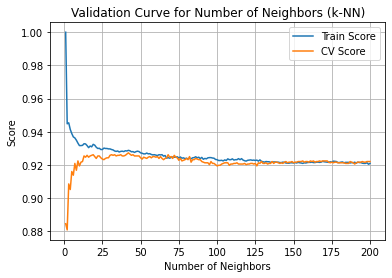

In [21]:
classifier_knn = KNeighborsClassifier()
train_scores, test_scores = validation_curve(classifier_knn, X_train, y_train, param_range=np.arange(1,201), param_name='n_neighbors', cv=4)

plt.figure()
plt.plot(np.arange(1,201), np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.arange(1,201), np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Validation Curve for Number of Neighbors (k-NN)")
plt.xlabel("Number of Neighbors")
plt.ylabel("Score")
plt.grid()
plt.savefig('rice_knn_validation_curve_1.png')
plt.show()

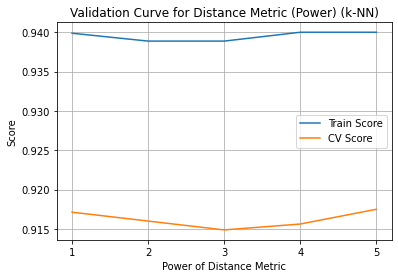

In [22]:
train_scores, test_scores = validation_curve(classifier_knn, X_train, y_train, param_name="p", param_range=np.arange(1,6), cv=4)

plt.figure()
plt.plot(np.arange(1,6), np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.arange(1,6), np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Validation Curve for Distance Metric (Power) (k-NN)")
plt.xlabel("Power of Distance Metric")
plt.ylabel("Score")
plt.grid()
plt.xticks(np.arange(1,6))
plt.savefig('rice_knn_validation_curve_2.png')
plt.show()

We use the `GridSearchCV` function to choose the best value of $k$ from a range of $1-200$ and $p$ between $1-5$. The best model chosen by the cross-validation process is $k=49$ and $p=5$, which has an accuracy of $93.61\%$ on the test set.

In [23]:
param_grid = {'n_neighbors': np.arange(1,201), 'p':np.arange(1,6)}
classifier_knn_best = GridSearchCV(classifier_knn, param_grid=param_grid, cv=4)

start_time = time.time()
classifier_knn_best.fit(X_train, y_train)
end_time = time.time()
time_train[3] = end_time-start_time
print("Best params for k-NN:",classifier_knn_best.best_params_)

start_time = time.time()
classifier_accuracy[3] = accuracy_score(y_test, classifier_knn_best.predict(X_test))
end_time = time.time()
time_infer[3] = end_time-start_time
print("Accuracy for best k-NN:", classifier_accuracy[3])

Best params for k-NN: {'n_neighbors': 49, 'p': 5}
Accuracy for best k-NN: 0.9361329833770778


In [24]:
confusion_matrix(y_test, classifier_knn_best.predict(X_test))

array([[470,  48],
       [ 25, 600]], dtype=int64)

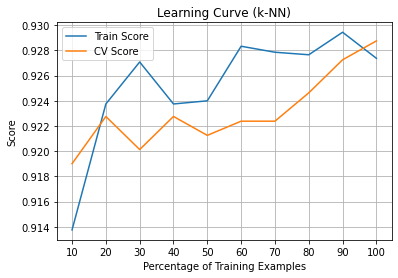

In [25]:
classifier_knn_learning = KNeighborsClassifier(n_neighbors=classifier_knn_best.best_params_['n_neighbors'], p=classifier_knn_best.best_params_['p'])
_, train_scores, test_scores = learning_curve(classifier_knn_learning, X_train, y_train, train_sizes=np.linspace(0.1,1.0,10), cv=4)

plt.figure()
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Learning Curve (k-NN)")
plt.xlabel("Percentage of Training Examples")
plt.ylabel("Score")
plt.xticks(np.linspace(0.1,1.0,10)*100)
plt.grid()
plt.savefig('rice_knn_learning_curve.png')
plt.show()

For the $k$-NN model, the learning curve shows that the although the accuracy scores have converged, the convergence score is not high enough, which means that there might be some bias in the model itself.

### SVM

The performance of the SVM classifier is shown next. The validation curves are shown first, with a varying regularizaion parameter $C$ as well as for different types of kernels. In order to plot the validation curve for the different kernels, the training set is further divided to create a validation set.

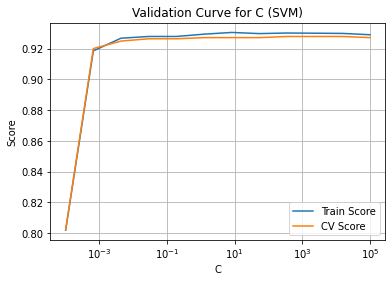

In [26]:
classifier_svm = svm.SVC(kernel='linear', random_state=42)
train_scores, test_scores = validation_curve(classifier_svm, X_train, y_train, param_name="C", param_range=np.logspace(-4,5,12), cv=4)

plt.figure()
plt.semilogx(np.logspace(-4,5,12), np.mean(train_scores, axis=1), label='Train Score')
plt.semilogx(np.logspace(-4,5,12), np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Validation Curve for C (SVM)")
plt.xlabel("C")
plt.ylabel("Score")
plt.grid()
plt.savefig('rice_svm_validation_curve_1.png')
plt.show()

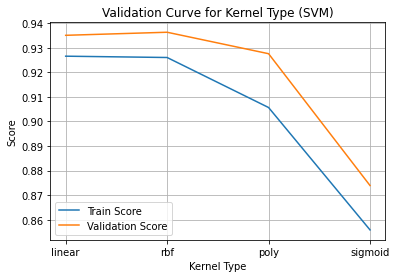

In [27]:
train_scores = np.zeros((4,1))
test_scores = np.zeros((4,1))

classifier_svm = svm.SVC(random_state=42, kernel='linear')
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
classifier_svm.fit(X_train_train, y_train_train)
train_scores[0] = accuracy_score(y_train_train, classifier_svm.predict(X_train_train))
test_scores[0] = accuracy_score(y_train_val, classifier_svm.predict(X_train_val))

classifier_svm = svm.SVC(random_state=42, kernel='rbf')
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
classifier_svm.fit(X_train_train, y_train_train)
train_scores[1] = accuracy_score(y_train_train, classifier_svm.predict(X_train_train))
test_scores[1] = accuracy_score(y_train_val, classifier_svm.predict(X_train_val))

classifier_svm = svm.SVC(random_state=42, kernel='poly')
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
classifier_svm.fit(X_train_train, y_train_train)
train_scores[2] = accuracy_score(y_train_train, classifier_svm.predict(X_train_train))
test_scores[2] = accuracy_score(y_train_val, classifier_svm.predict(X_train_val))

classifier_svm = svm.SVC(random_state=42, kernel='sigmoid')
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
classifier_svm.fit(X_train_train, y_train_train)
train_scores[3] = accuracy_score(y_train_train, classifier_svm.predict(X_train_train))
test_scores[3] = accuracy_score(y_train_val, classifier_svm.predict(X_train_val))

plt.figure()
plt.plot(np.arange(0,4), np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.arange(0,4), np.mean(test_scores, axis=1), label='Validation Score')
plt.legend()
plt.title("Validation Curve for Kernel Type (SVM)")
plt.xlabel("Kernel Type")
plt.ylabel("Score")
plt.grid()
plt.xticks(np.arange(4),['linear','rbf','poly','sigmoid'])
plt.savefig('rice_svm_validation_curve_2.png')
plt.show()

As seen from the validation curve, the train score keeps increasing, but the CV score drops beyond a certain value of the regularization parameter $C$. Therefore, we do grid search on the hyper-parameter $C$. For a value of $C=1.233$ and with the RBF kernel, the accuracy of the SVM classifier on the test set is $93.09\%$.

In [28]:
param_grid = {'C': np.logspace(-4,5,12), 'kernel': ['linear','rbf','poly','sigmoid']}
classifier_svm_best = GridSearchCV(classifier_svm, param_grid=param_grid, cv=4)

start_time = time.time()
classifier_svm_best.fit(X_train, y_train)
end_time = time.time()
time_train[4] = end_time-start_time
print("Best params for SVM:",classifier_svm_best.best_params_)

start_time = time.time()
classifier_accuracy[4] = accuracy_score(y_test, classifier_svm_best.predict(X_test))
end_time = time.time()
time_infer[4] = end_time-start_time
print("Accuracy for best SVM:", classifier_accuracy[4])

Best params for SVM: {'C': 1.232846739442066, 'kernel': 'rbf'}
Accuracy for best SVM: 0.9308836395450568


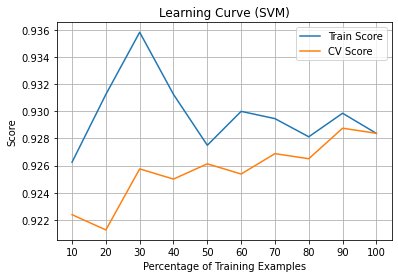

In [29]:
classifier_svm_learning = svm.SVC(random_state=42, C=classifier_svm_best.best_params_['C'], kernel=classifier_svm_best.best_params_['kernel'])
_, train_scores, test_scores = learning_curve(classifier_svm_learning, X_train, y_train, train_sizes=np.linspace(0.1,1.0,10), cv=4)

plt.figure()
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Learning Curve (SVM)")
plt.xlabel("Percentage of Training Examples")
plt.ylabel("Score")
plt.xticks(np.linspace(0.1,1.0,10)*100)
plt.grid()
plt.savefig('rice_svm_learning_curve.png')
plt.show()

Finally we look at the learning curve and see that the train score and CV score have converged to a relatively low value for maximum percentage of training samples, which points to the fact that the SVM classifier is biased, and a more complex model could help increase its performance.

### Boosting

The final classifier that we show here is the boosting method. We use the AdaBoost classifier with a single leaf decision tree as the weak learner. The hyper-parameters chosen for this classifier are the number of weak learners and the learning rate.

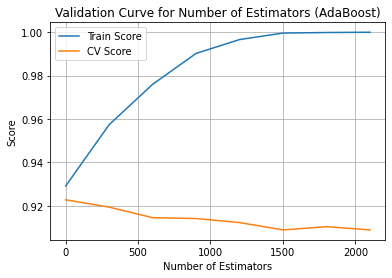

In [30]:
classifier_adaboost = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=1, min_samples_leaf=1), random_state=42)
train_scores, test_scores = validation_curve(classifier_adaboost, X_train, y_train, param_name="n_estimators", param_range=np.arange(1,2102,300), cv=4)

plt.figure()
plt.plot(np.arange(1,2102,300), np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.arange(1,2102,300), np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Validation Curve for Number of Estimators (AdaBoost)")
plt.xlabel("Number of Estimators")
plt.ylabel("Score")
plt.grid()
plt.savefig('rice_boosting_validation_curve_1.png')
plt.show()

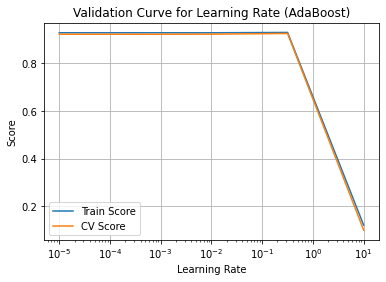

In [31]:
train_scores, test_scores = validation_curve(classifier_adaboost, X_train, y_train, param_name="learning_rate", param_range=np.logspace(-5,1,5), cv=4)

plt.figure()
plt.semilogx(np.logspace(-5,1,5), np.mean(train_scores, axis=1), label='Train Score')
plt.semilogx(np.logspace(-5,1,5), np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Validation Curve for Learning Rate (AdaBoost)")
plt.xlabel("Learning Rate")
plt.ylabel("Score")
plt.grid()
plt.savefig('rice_boosting_validation_curve_2.png')
plt.show()

In [32]:
param_grid = {'learning_rate': np.logspace(-5,1,5), 'n_estimators': np.arange(1,2102,300)}
classifier_adaboost_best = GridSearchCV(classifier_adaboost, param_grid=param_grid, cv=4)

start_time = time.time()
classifier_adaboost_best.fit(X_train, y_train)
end_time = time.time()
time_train[5] = end_time-start_time
print("Best params for AdaBoost:",classifier_adaboost_best.best_params_)

start_time = time.time()
classifier_accuracy[5] = accuracy_score(y_test, classifier_adaboost_best.predict(X_test))
end_time = time.time()
time_infer[5] = end_time-start_time
print("Accuracy for best AdaBoost:", classifier_accuracy[5])

Best params for AdaBoost: {'learning_rate': 0.01, 'n_estimators': 901}
Accuracy for best AdaBoost: 0.931758530183727


In [33]:
confusion_matrix(y_test, classifier_adaboost_best.predict(X_test))

array([[466,  52],
       [ 26, 599]], dtype=int64)

For a learning rate of $0.01$ and with approximately $900$ weak learners, the AdaBoost classifier has a test set accuracy of $93.18\%$. 

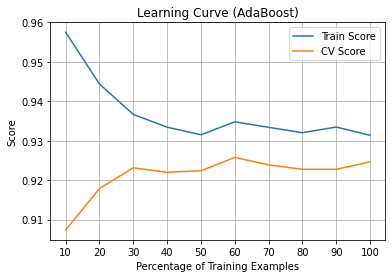

In [34]:
classifier_adaboost_learning_curve = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=1, min_samples_leaf=1), random_state=42, n_estimators=classifier_adaboost_best.best_params_['n_estimators'], learning_rate=classifier_adaboost_best.best_params_['learning_rate'])
_, train_scores, test_scores = learning_curve(classifier_adaboost_learning_curve, X_train, y_train, train_sizes=np.linspace(0.1,1.0,10), cv=4)

plt.figure()
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(train_scores, axis=1), label='Train Score')
plt.plot(np.linspace(0.1,1.0,10)*100, np.mean(test_scores, axis=1), label='CV Score')
plt.legend()
plt.title("Learning Curve (AdaBoost)")
plt.xlabel("Percentage of Training Examples")
plt.ylabel("Score")
plt.xticks(np.linspace(0.1,1.0,10)*100)
plt.grid()
plt.savefig('rice_boosting_learning_curve.png')
plt.show()

The learning curve shows convergence of the train score and the CV score at the highest percentage of training examples, and therefore, the AdaBoost classifier suffers from high bias, which means introducing more complexity in the model would be beneficial to increasing its performance.

### Time and Performance Analysis

The performance and efficiency of the classifiers are now compared. For the training time, the entire time taken to complete the grid search is included since searching for the best hyper-parameter is also a part of the training process. 

In [35]:
time_train

array([ 11.77758503, 306.79182959, 330.40352559, 325.6050117 ,
       913.31964087, 457.60513067])

In [36]:
time_infer

array([0.00097227, 0.00200605, 0.00188732, 0.14162087, 0.05485225,
       0.21044326])

In [38]:
classifier_accuracy

array([0.93000875, 0.92213473, 0.93175853, 0.93613298, 0.93088364,
       0.93175853])

In [44]:
classifiers = ('DT', 'NN (ML)', 'NN (SL)', 'k-NN', 'SVM', 'AdaBoost')
y_ticks = np.arange(len(classifiers))

We first look at the training times for the different classifiers. For the RCO dataset, the most surprising element is the fact that the SVM takes the most amount of time to train. This might be because of the large number of training examples in the dataset, which leads to the optimization problem being solved slowly. Decision tree is trained the fastest as expected as the max depth of the tree is controlled using the max depth hyper-parameter. The high training time for $k$-NN is mainly because of the large number of points to be searched in the grid (number of neighbors). Both AdaBoost and neural network training times are also relatively high because the neural network needs to use backpropagation for gradient computation, while for AdaBoost, the significant number of weak learners takes a toll on the training time.

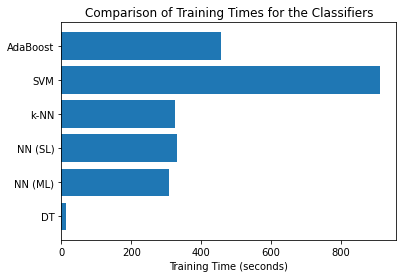

In [48]:
plt.figure()
plt.barh(y_ticks, time_train)
plt.gca().set_yticks(y_ticks)
plt.gca().set_yticklabels(classifiers)
plt.title('Comparison of Training Times for the Classifiers')
plt.xlabel('Training Time (seconds)')
plt.savefig('rice_training.png', dpi=300, bbox_inches='tight')
plt.show()

Inference time for decision trees is also low as expected since tree traversal is a trivial process. For the $k$-NN classifier, since the distance to each neighbor has to be computed, the process is slow. AdaBoost is the slowest in this case as the number of weak learners is high, and inference is completed for each weak learner. Finally, both SVM and the NN classifiers are relatively faster since SVM only uses a linear function, and the NN classifiers only need a single forward pass for each test case. 

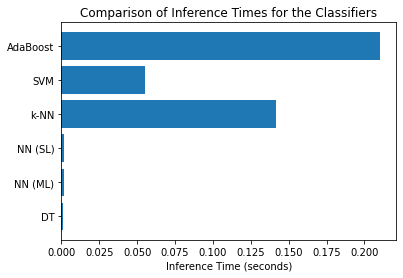

In [49]:
plt.figure()
plt.barh(y_ticks, time_infer)
plt.gca().set_yticks(y_ticks)
plt.gca().set_yticklabels(classifiers)
plt.title('Comparison of Inference Times for the Classifiers')
plt.xlabel('Inference Time (seconds)')
plt.savefig('rice_inference.png', dpi=300, bbox_inches='tight')
plt.show()

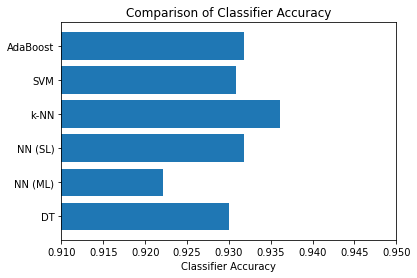

In [50]:
plt.figure()
plt.barh(y_ticks, classifier_accuracy)
plt.gca().set_yticks(y_ticks)
plt.gca().set_yticklabels(classifiers)
plt.title('Comparison of Classifier Accuracy')
plt.xlabel('Classifier Accuracy')
plt.gca().set_xlim(0.91, 0.95)
plt.savefig('rice_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()